In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import warnings
from sklearn.metrics import pairwise_distances 
warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=UserWarning)
from tqdm import tqdm

In [9]:
data = pd.read_csv('data.csv')

In [10]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Предобработка данных

**Описание**

1. С пустым описанием стоимость покупки всегда нулевая. Поэтому все чеки с пустым описанием удаляются.
2. Удаляются чеки с нулевой стоимостью,так как описание неудовлетворительное.
3. Чеки с отрицательным количеством (2% от общей выборки). Гипотеза: возврат. Решение: взять модуль, так как товар был куплен, но по каким-то причинам возвращен. Считаю, что анализ не исказит. 
4. Товары с описанием Discount,POSTAGE, SAMPLES удаляются

In [11]:
#с пустым описанием только нулевая стоимость
data[(data.Description.isna())&(data.UnitPrice>0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [12]:
data = data[~((data.Description.isna()))]

In [13]:
# для нулевой или отрицательной стоимости описание товара неудовлетворительное почти всегда
data[(data.UnitPrice<=0)&(~data.Description.isna())].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6391,536941,22734,amazon,20,12/3/2010 12:08,0.0,NaN,United Kingdom
6392,536942,22139,amazon,15,12/3/2010 12:08,0.0,NaN,United Kingdom
7313,537032,21275,?,-30,12/3/2010 16:50,0.0,NaN,United Kingdom
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
13217,537425,84968F,check,-20,12/6/2010 15:35,0.0,NaN,United Kingdom


In [14]:
data = data[data.UnitPrice>0]

In [15]:
# данные с отрицательным количество ничем не примечательны. Переводим в положительную зону.
data[data.Quantity<0].head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [16]:
data["Quantity"] = np.abs(data.Quantity)

In [17]:
#Товары с описанием Discount удаляются
print("Количество товаров с описанием Discount",len(data[data.Description=="Discount"]))
ln_desc = data["Description"].apply(lambda x: len(x.split()))
data[ln_desc<2].Description.unique()

Количество товаров с описанием Discount 77


array(['POSTAGE', 'Discount', 'CARRIAGE', 'Manual', 'SOMBRERO ',
       'SAMPLES'], dtype=object)

In [18]:
data=data[~data.Description.isin(["Discount","POSTAGE", "SAMPLES"])]

In [19]:
data.StockCode = data.StockCode.str.lower()

# 2. Построение матриц А, В


In [20]:
less3q_per_ch_mask = data.InvoiceNo.value_counts() > 6
more_6=less3q_per_ch_mask[less3q_per_ch_mask].index
data = data[(data.InvoiceNo.isin(more_6))]

In [21]:
# количество уникальных чеков
data.InvoiceNo.unique().shape

(15036,)

In [22]:
# количество уникальных товаров
data.Description.unique().shape

(4003,)

In [23]:
data.Country.value_counts().head()

United Kingdom    473508
Germany             8452
France              7952
EIRE                7932
Spain               2378
Name: Country, dtype: int64

In [24]:
# change invoiceNo to IndexOfCheque
init_index = data.InvoiceNo.unique()
Invoice_to_int = {invoice:i for i,invoice in enumerate(init_index)}

In [25]:
data["cheque_id"] = data["InvoiceNo"].apply(lambda x: Invoice_to_int[x])

In [26]:
init_index = data.InvoiceNo.unique()
Invoice_to_int = {invoice:i for i,invoice in enumerate(init_index)}

In [27]:
A=pd.pivot_table(data, values='Quantity', index=["cheque_id"],
                       columns=['StockCode'])

In [28]:
B = A>0
B=B.astype(np.int8) # invert from bool to int0

In [29]:
A.fillna(0,inplace=True) # change nans with zeros

**Клипируем количество покупок для одного чека. Если этого не сделать, ошибка будет сильнее на этих чеках, и эмбеддинг для товара будет переобучен на конкретный чек. Порог  берем равным 20 (3%выборки)**

In [30]:
vals=A.values.reshape(-1)
vals[(vals>20)].shape # Будем клипировать высокие объемы покупки

(51322,)

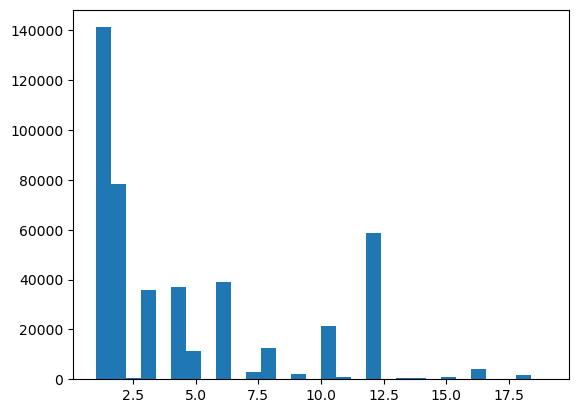

In [31]:
_=plt.hist(vals[(vals>0)&(vals<20)],bins=30)

In [32]:
vals[vals==1].shape

(139506,)

In [33]:
vals[vals>0].shape

(506306,)

In [34]:
A.clip(0,20,inplace=True)

# 3. Эмбеддинги
**В качестве валидации на количество компонент, используем метрику MSE.**

In [28]:
def eval_ncomponents(matrix, n_comp_lst,):
    for n_comp in n_comp_lst:
        model = NMF(n_components=n_comp, init='random', random_state=0,max_iter=1000)
        W = model.fit_transform(matrix) # embeddings for cheques
        H = model.components_ # embeddings for goods
        mse = (((W@H)-matrix.values)**2).sum()/W.shape[0]/H.shape[1]
        print(f"MSE with {n_comp} components: ", np.round(mse,4))

In [395]:
print("Matrix A ...")
eval_ncomponents(A,[2,4,6,8,10,12,14,15])
# eval_ncomponents(A,[2,4,6])

Matrix A ...
MAE with 2 components:  1.3338
MAE with 4 components:  1.2997
MAE with 6 components:  1.271
MAE with 8 components:  1.2492
MAE with 10 components:  1.2321
MAE with 12 components:  1.2134
MAE with 14 components:  1.1958
MAE with 15 components:  1.1893


In [421]:
print("Matrix B ...")
eval_ncomponents(B,[2,4,6,8,10,12,14,15])

Matrix B ...
MAE with 2 components:  0.0081
MAE with 4 components:  0.0079
MAE with 6 components:  0.0078
MAE with 8 components:  0.0077
MAE with 10 components:  0.0076
MAE with 12 components:  0.0075
MAE with 14 components:  0.0074
MAE with 15 components:  0.0074


**Размерность возьмем равную 4: качество не отличается сильно от моделей с большим количеством компонент, но переобучения не возникнет.**

In [535]:
model = NMF(n_components=4, init='random', random_state=0)
W_A = model.fit_transform(A) # embeddings for cheques
H_A = model.components_ # embeddings for goods

model = NMF(n_components=4, init='random', random_state=0,)
W_B = model.fit_transform(B) # embeddings for cheques
H_B = model.components_ # embeddings for goods

In [42]:
H_B.shape

(2, 3802)

In [44]:
W_B.shape

(15036, 2)

# 4. Кластеризация

In [45]:
from sklearn.cluster import DBSCAN, KMeans,SpectralClustering,AgglomerativeClustering
from collections import Counter

In [72]:
def plot_clusters(matrix, labels):
    plt.figure(figsize=(15,15))
    tsne = TSNE(n_components=2)
    transformed_embeddings = tsne.fit_transform(matrix)
    plt.scatter(transformed_embeddings[:, 0], transformed_embeddings[:, 1], c=labels)

def apply_clustering(model,n_clusters, matrix):
    try:
        model = model(n_clusters=n_clusters)
    except:
        print(model)
        model = model()
    model.fit(matrix)
    return model.labels_


# Ни стандартный Kmeans, ни иерархическая кластеризация, ни даже спектральная не справляются с задачей. 

C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The

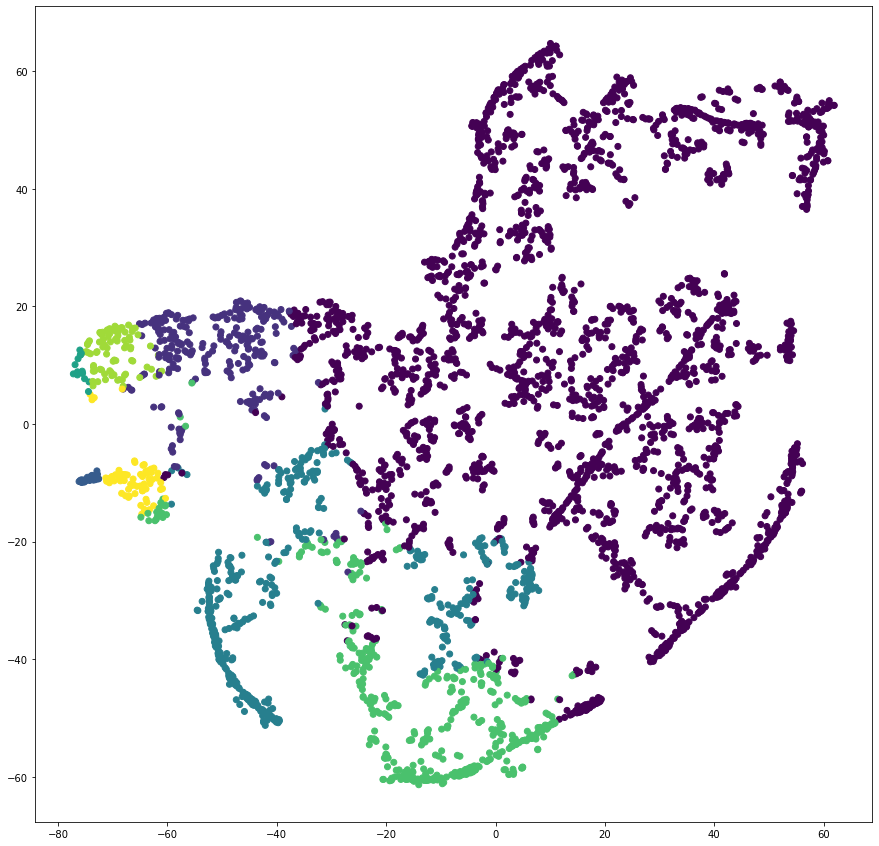

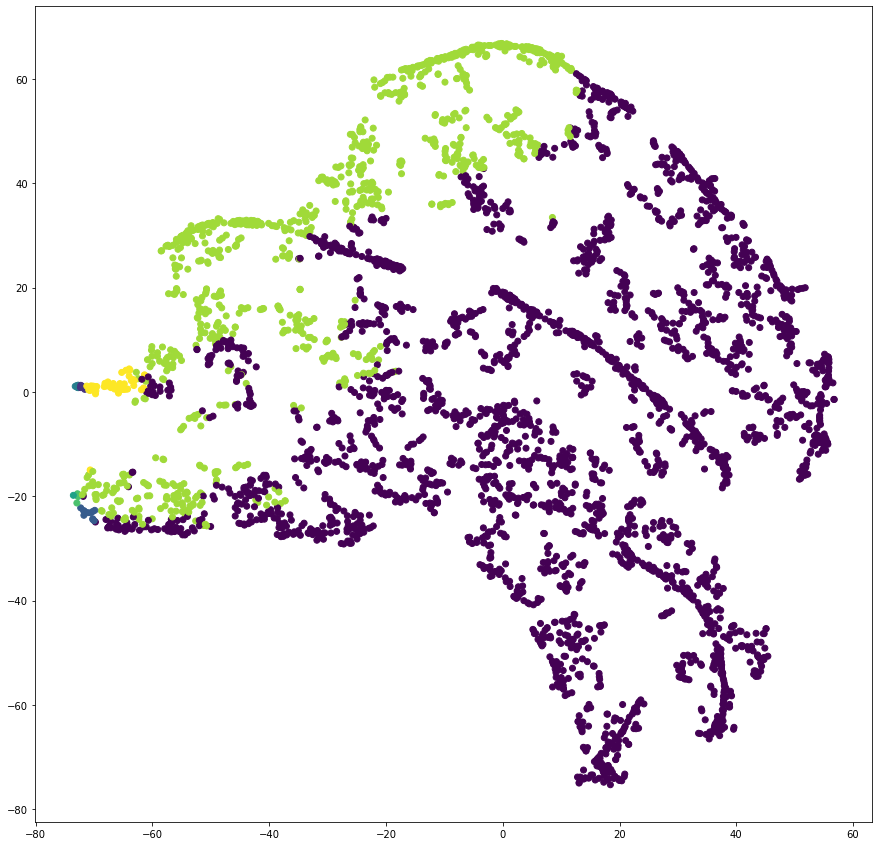

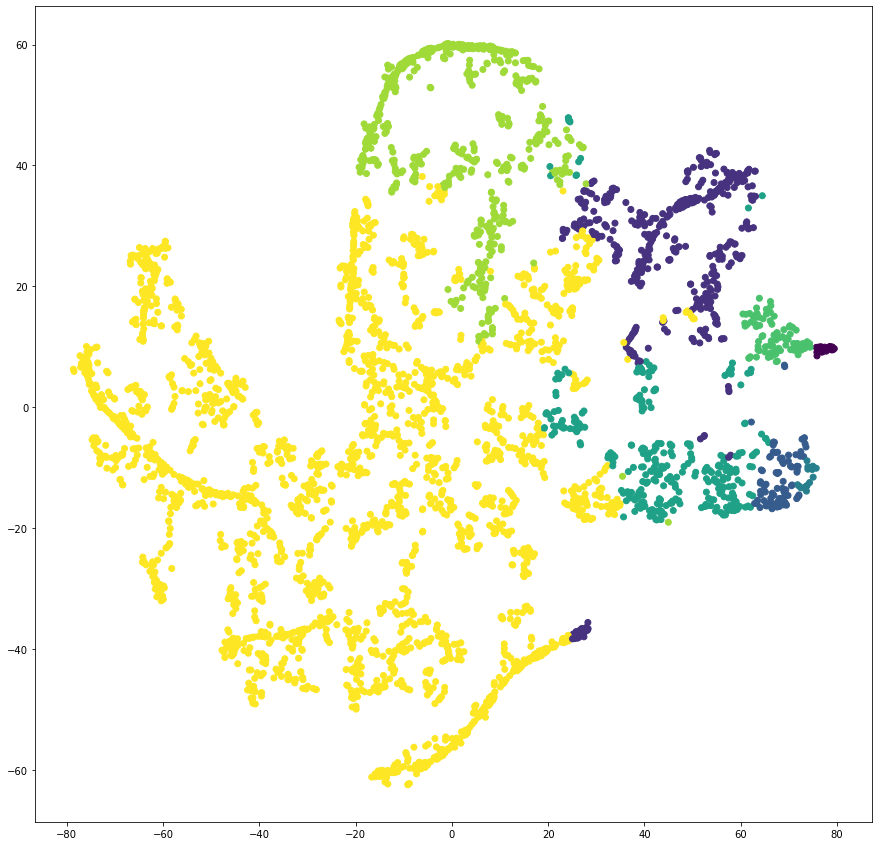

In [71]:
for alg in [ KMeans,SpectralClustering,AgglomerativeClustering]:
    plot_clusters(H_B.T, apply_clustering(alg, 8, H_B))

# Причина
**Ниже я представил scatter plot эмбеддингов размерности два. Поскольку качество эмбеддингов размерности 2 высокая и мало отличается от качества с более высокой размерностью, посмотрим на их распределение**
**Анализ будет проводится для H_B**

**Наибольшее количество точек находится вблизи нуля, поэтому ни один из алгоритмов не может выдать примерно равномерные по количеству элементов кластеры**


In [ ]:
def plot_embs(matrix,title):
    plt.scatter(matrix[:,0],matrix[:,1])

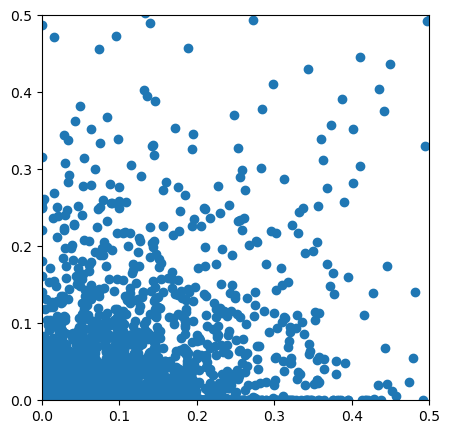

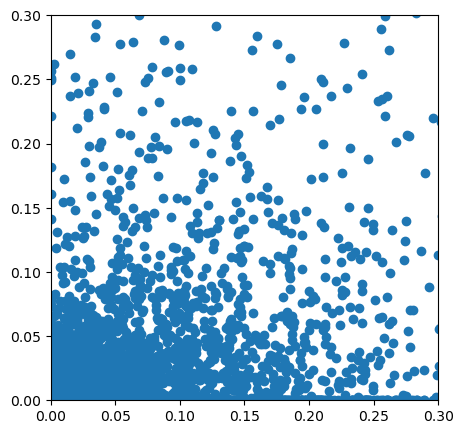

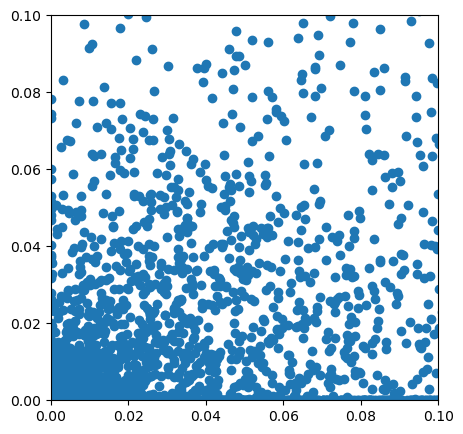

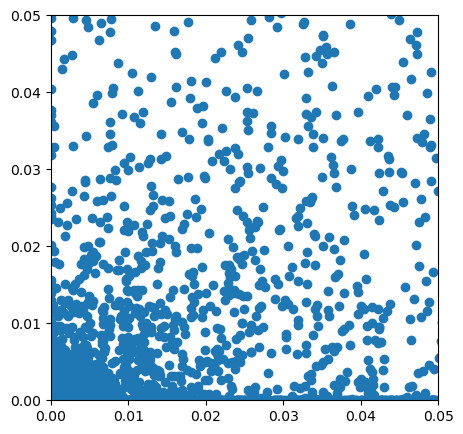

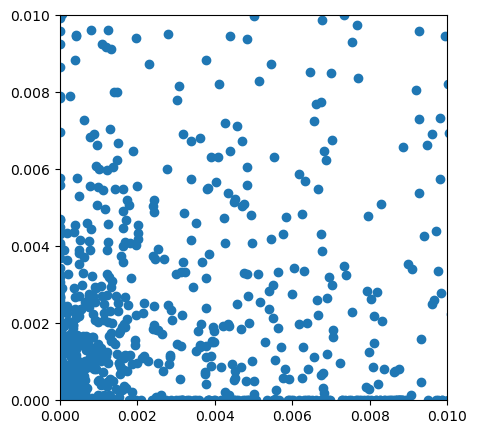

In [56]:
for i in [0.5,0.3,.1,.05,.01]:
    plt.figure(figsize=(5,5))
    plt.scatter(H_B[0,:],H_B[1,:])
    plt.xlim(0,i)
    plt.ylim(0,i)

# Решение проблемы

**Прежде  применим TSNE, а затем проведем кластеризацию**.

In [536]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [537]:
H_A, H_B = H_A.T, H_B.T

In [538]:
tsne = TSNE(n_components=2)
H_A = tsne.fit_transform(H_A)
H_B = tsne.fit_transform(H_B)

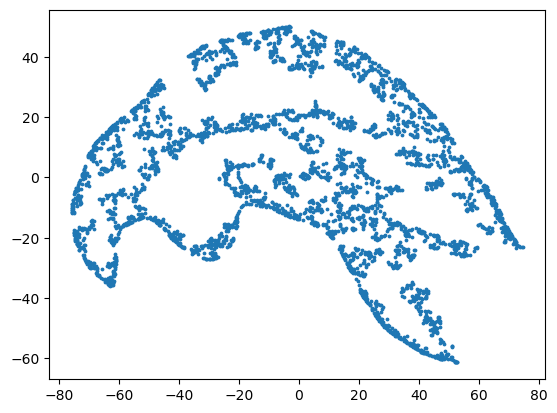

In [69]:
plt.scatter(H_A[:,0],H_A[:,1], s=3)

# В таком пространстве проведем кластеризацию

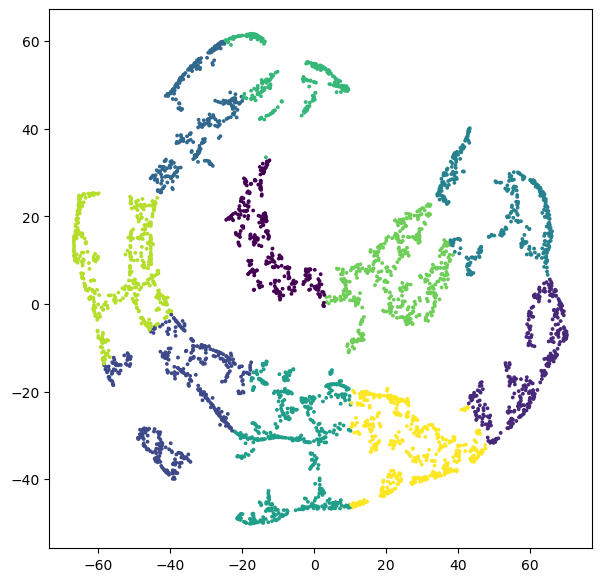

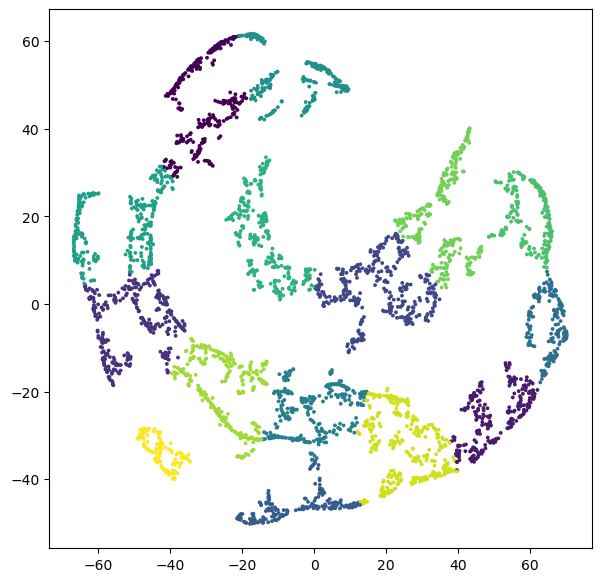

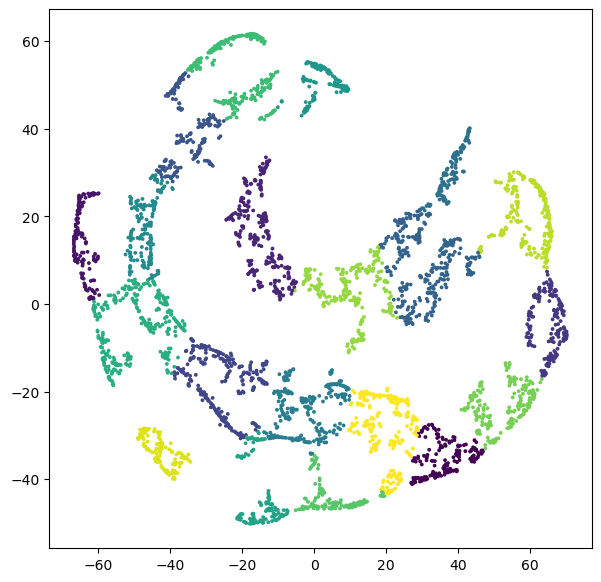

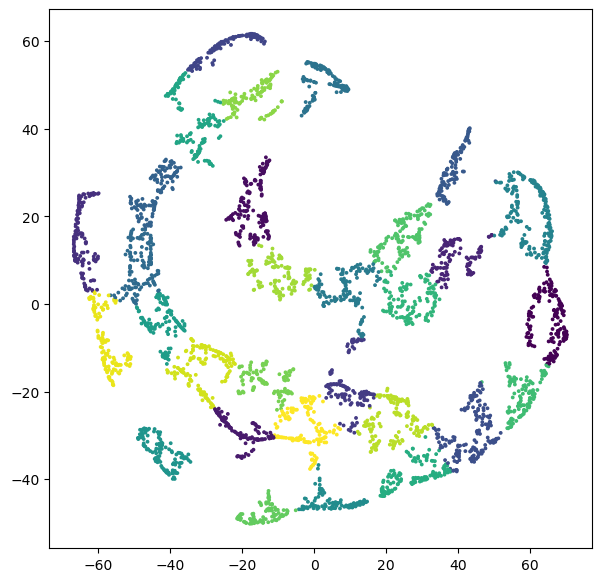

In [115]:
dct_B = {}
for n in [10,15,20,30]:
    plt.figure(figsize=(7,7))
    labels = apply_clustering(KMeans,n, H_B)
    plt.scatter(H_B[:,0],H_B[:,1],c=labels,s=3)
    dct_B[n] = labels

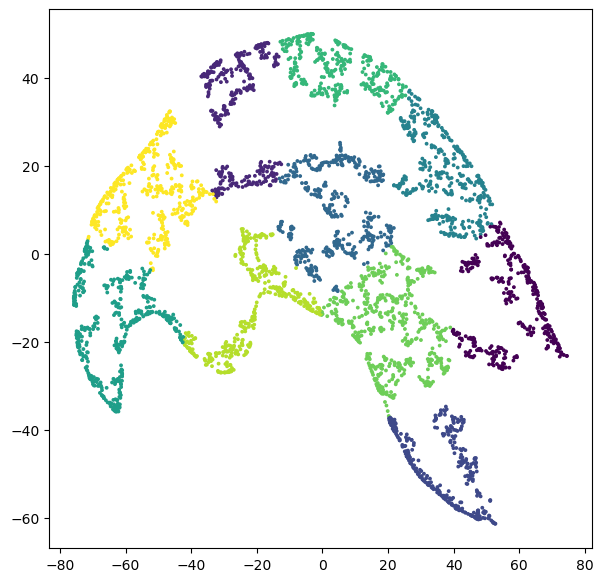

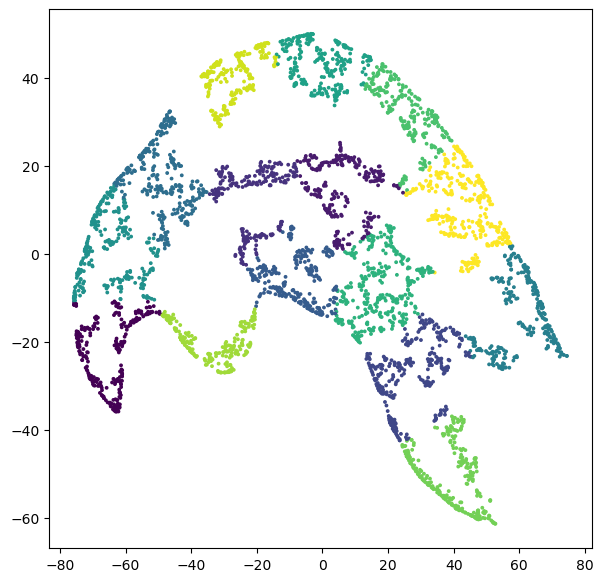

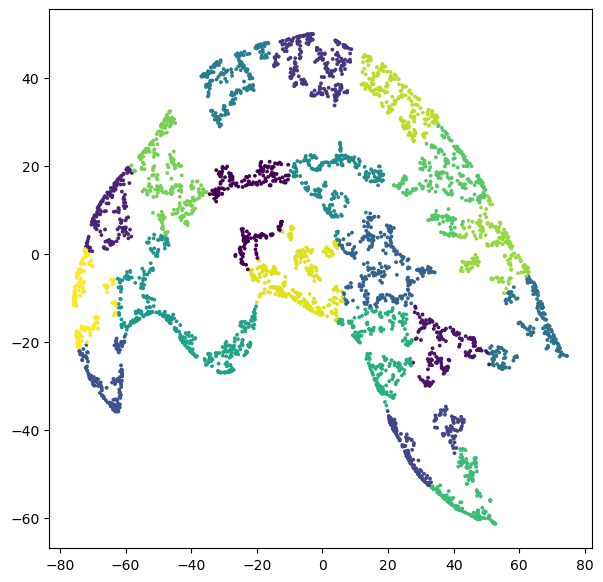

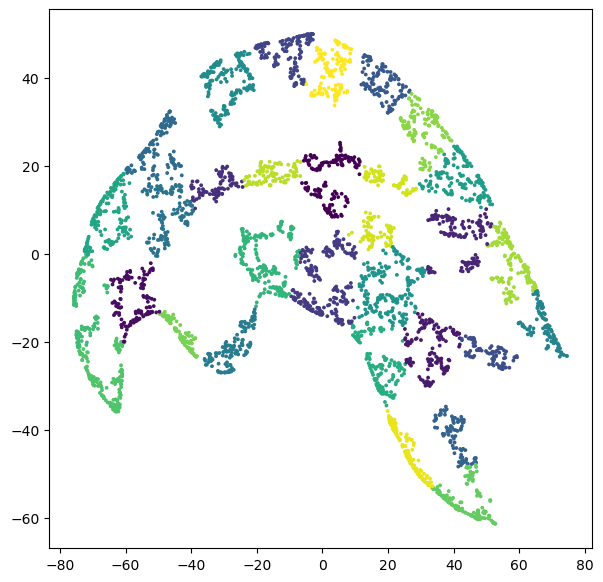

In [116]:
dct_A = {}
for n in [10,15,20,30]:
    plt.figure(figsize=(7,7))
    labels = apply_clustering(KMeans,n, H_A)
    plt.scatter(H_A[:,0],H_A[:,1],c=labels,s=3)
    dct_A[n] = labels

# В дальнейшем будем использовать количество кластеров, равное 20. Как мы видим, кластеры получились равномерные.

In [205]:
Counter(dct_A[20])

Counter({9: 198,
         18: 257,
         11: 173,
         5: 143,
         10: 172,
         6: 243,
         16: 175,
         1: 154,
         15: 231,
         7: 181,
         17: 198,
         3: 222,
         8: 189,
         2: 156,
         12: 209,
         13: 157,
         0: 195,
         14: 249,
         19: 134,
         4: 166})

In [206]:
Counter(dct_B[20])

Counter({14: 119,
         2: 243,
         13: 219,
         4: 264,
         16: 214,
         8: 239,
         1: 141,
         17: 221,
         19: 222,
         0: 160,
         3: 173,
         6: 292,
         5: 181,
         12: 284,
         10: 122,
         9: 163,
         11: 124,
         18: 117,
         15: 190,
         7: 114})

In [539]:
labels_A_init = apply_clustering(KMeans,20, H_A)
labels_B_init = apply_clustering(KMeans,20, H_B)

# 5. Добавление цены.
# Заметим, что в отношении цены наблюдается та же закономерность, распределение по хи-квадрат.

**Задача: организовать матрицу эмбеддингов, которая включала бы и цену**

**Решение: к первоначальным матрицам H_A, H_B пристыковать вектор цены, а затем применить TSNE.**

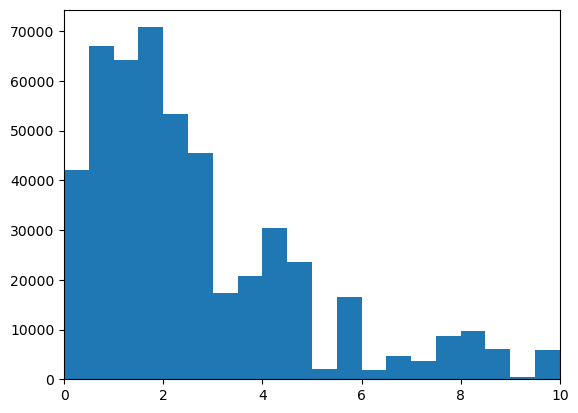

In [148]:
plt.xlim(0,10)
vals = data.UnitPrice.values
_=plt.hist(vals[vals<50],bins=100)

In [149]:
model = NMF(n_components=4, init='random', random_state=0)
W_A = model.fit_transform(A) # embeddings for cheques
H_A = model.components_ # embeddings for goods

model = NMF(n_components=4, init='random', random_state=0,)
W_B = model.fit_transform(B) # embeddings for cheques
H_B = model.components_ # embeddings for goods

In [186]:
# вычисляем среднюю цену каждого товара
prices_lst = []
pr_df = data.groupby("StockCode")["UnitPrice"].mean()
dct_pr = dict(zip(pr_df.index,pr_df.values))
for c in A.columns:
    prices_lst.append(dct_pr[c])


In [163]:
H_A, H_B = H_A.T, H_B.T

In [203]:
H_A=np.concatenate((H_A, np.array(prices_lst).reshape(-1,1)),axis=1)
H_B=np.concatenate((H_B, np.array(prices_lst).reshape(-1,1)),axis=1)

# 6. Кластеризация
**Переводим в пространство меньшей размерности и кластеризуем. Затем выводится скаттер-плот, как выглядят наши кластеры, спроецированные на двухмерное пространство**

In [208]:
# теперь количество компонент возьмем равным 3
tsne = TSNE(n_components=3)
H_A = tsne.fit_transform(H_A)
H_B = tsne.fit_transform(H_B)

In [221]:
labels_A = apply_clustering(KMeans,20, H_A)
labels_B = apply_clustering(KMeans,20, H_B)

In [222]:
tsne = TSNE(n_components=2)
tsneH_A = tsne.fit_transform(H_A)
tsneH_B = tsne.fit_transform(H_B)

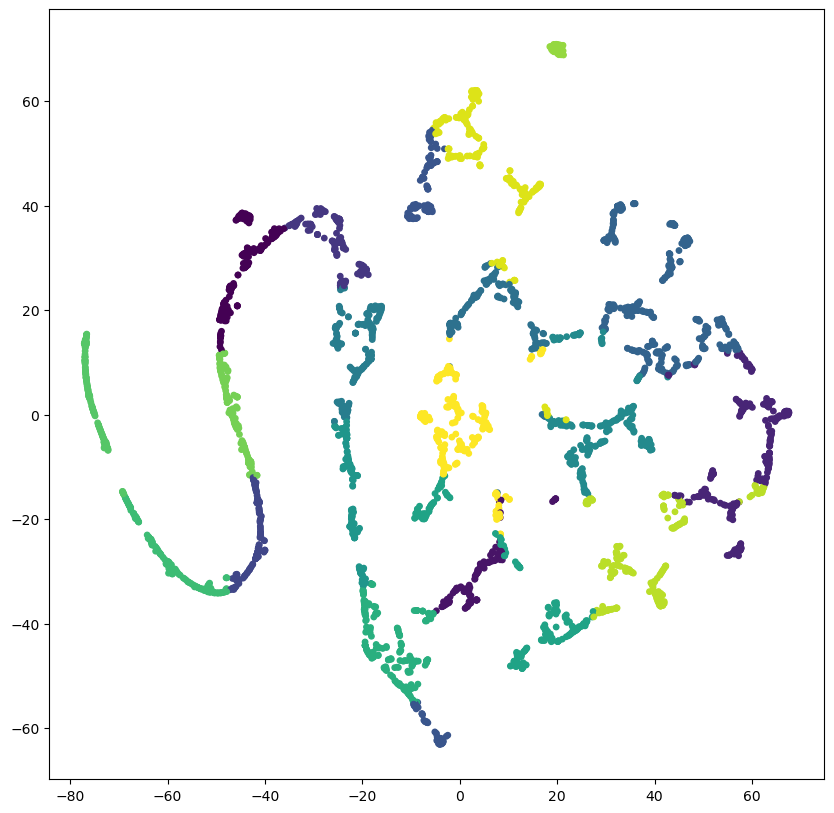

In [223]:
plt.figure(figsize=(10,10))
plt.scatter(tsneH_A[:,0],tsneH_A[:,1],c=labels_A,s=15)

# 7. Поиск товаров-заменителей

#  Алгоритм состоит в поиске высокоскоррелированных товаров с точки зрения чеков.



In [464]:
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity

In [471]:
df_sim = pd.DataFrame(cosine_similarity(A.T), columns=count_df.columns, index=count_df.columns)

In [475]:
threshold=0.95
for i,c1 in enumerate(df_sim.columns[:-1]):
    if df_sim.loc[c1][i+1:].values.max()<threshold:
        continue
    print(f"good {c1} can be substitued by: ")
    lst_s = []
    for c2 in df_sim.columns[i+1:]:
        if df_sim.loc[c1,c2]>threshold:
            lst_s.append(c2)
    print(lst_s)
            
    

good 17028j can be substitued by: 
['84795c']
good 17109d can be substitued by: 
['20827']
good 20871 can be substitued by: 
['21160', '21186']
good 21144 can be substitued by: 
['21412']
good 21160 can be substitued by: 
['21186']
good 21367 can be substitued by: 
['21368']
good 21645 can be substitued by: 
['79323b']
good 21769 can be substitued by: 
['22765', '22833']
good 22765 can be substitued by: 
['22833']
good 22868 can be substitued by: 
['22871', '22874', '22876']
good 22871 can be substitued by: 
['22874', '22876']
good 22874 can be substitued by: 
['22876']
good 22879 can be substitued by: 
['22880', '22882', '22884', '22887', '22888', '22889']
good 22880 can be substitued by: 
['22887', '22888']
good 22882 can be substitued by: 
['22887']
good 22884 can be substitued by: 
['22887', '22888']
good 22887 can be substitued by: 
['22888', '22889']
good 22888 can be substitued by: 
['22889']
good 23446 can be substitued by: 
['23447']
good 23555 can be substitued by: 
['23556']

# 8. Для поиска якоря и сопутствующих товаров воспользуемся теоремой Байеса.

$$P(A|B) = P(A,B) / P(B)$$

$P(B)$ - количество покупок товара, деленное на количество всех купленных товаров.

$P(A,B)$ - сумма по всем чекам количества покупок товаров А и В в одном чеке, деленное на количество "двоек"

**Вычислив условные вероятности и установив порог отсечения, найдем якоря, а значит и сопутствующие**

In [243]:
sm=B.sum(axis=0)
P_marginal = sm / sm.sum()

In [265]:
B

StockCode,10002,10080,10120,10123c,10124a,10124g,10125,10133,10135,11001,...,dcgssboy,dcgssgirl,dot,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m,pads
cheque_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [279]:
count_df = pd.DataFrame(index=B.columns,columns=B.columns).fillna(0)

In [309]:
# count_df.to_csv("count_df",index=0)

In [307]:
for i in tqdm(range(len(count_df.columns))):
    for j in range(i+1,len(count_df.columns)):
        c1, c2 = count_df.columns[i],count_df.columns[j]
        sm = (B[c1] * B[c2]).values.sum()
        count_df.loc[c1,c2] = sm
        count_df.loc[c2,c1] = sm

100%|██████████| 3802/3802 [24:49<00:00,  2.55it/s]


In [310]:
count_df

StockCode,10002,10080,10120,10123c,10124a,10124g,10125,10133,10135,11001,...,dcgssboy,dcgssgirl,dot,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m,pads
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0,0,2,1,0,0,5,3,12,3,...,0,0,21,0,0,0,0,0,1,0
10080,0,0,0,0,0,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
10120,2,0,0,1,0,0,1,1,2,1,...,0,0,0,0,0,0,0,0,1,0
10123c,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10124a,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gift_0001_30,0,0,0,0,0,0,0,1,1,0,...,0,1,7,1,1,0,0,0,0,0
gift_0001_40,0,0,0,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,0,0,0
gift_0001_50,0,1,0,0,0,0,1,2,2,1,...,0,0,4,1,0,0,0,0,0,0


In [313]:
full_dual_prob = (B.sum(axis=1).values * (B.sum(axis=1).values - 1)).sum() / 2

In [327]:
P_dual = count_df/ full_dual_prob

In [328]:
cond_prob = P_dual / P_marginal

In [329]:
cond_prob # P[i,j] = P(j|i)

StockCode,10002,10080,10120,10123c,10124a,10124g,10125,10133,10135,11001,...,dcgssboy,dcgssgirl,dot,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m,pads
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.000000,0.000000,0.001225,0.005919,0.0,0.000000,0.000998,0.000279,0.001268,0.00048,...,0.0,0.000000,0.000535,0.00000,0.000000,0.0,0.0,0.000000,0.000089,0.0
10080,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000093,0.000000,0.00016,...,0.0,0.000000,0.000025,0.00222,0.000000,0.0,0.0,0.004439,0.000089,0.0
10120,0.000507,0.000000,0.000000,0.005919,0.0,0.000000,0.000200,0.000093,0.000211,0.00016,...,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000089,0.0
10123c,0.000254,0.000000,0.000612,0.000000,0.0,0.000000,0.000200,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0
10124a,0.000000,0.000000,0.000000,0.000000,0.0,0.008878,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gift_0001_30,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000093,0.000106,0.00000,...,0.0,0.001366,0.000178,0.00222,0.001973,0.0,0.0,0.000000,0.000000,0.0
gift_0001_40,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000106,0.00000,...,0.0,0.000000,0.000076,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0
gift_0001_50,0.000000,0.000807,0.000000,0.000000,0.0,0.000000,0.000200,0.000186,0.000211,0.00016,...,0.0,0.000000,0.000102,0.00222,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [478]:
dct_anchor = {}
threshold = 0.015
for c in tqdm(cond_prob.columns):
    dct_anchor[c] = []
    cur_row = cond_prob.loc[c]
    for key in cur_row.index:
        if cur_row.loc[key] > threshold:
            dct_anchor[c].append(key)
            

        
    

100%|██████████| 3802/3802 [01:41<00:00, 37.35it/s]


In [480]:
anchors = {k:dct_anchor[k] for k in dct_anchor if len(dct_anchor[k])>0}

<h1>Задание</h1>
<b>Задача:</b>
<ol>
<li>Изучите датасэт, обработайте отрицательные продажи, обработайте специальные строки, которые не являются товарами и т.д.</li>
<li>Построить матрицу (A) чеки-товары, чтобы на пересечении оказалось число товаров (Quantity). Построить матрицу (B) чеки-товары, чтобы на пересечении оказалось число 1 - если была покупка, 0 - иначе.</li>
<li>Получите эмбединги товаров по матрицам А и B.
Для этого можно использовать SVD и NMF/NNMF c разным числом компанент (до 15). Оцените качество разложений. Выберите лучшее разложение для варианта А и B.</li>
    <li>Сделайте кластеризацию в полученом пространстве в лучших эмбедингах А и B. Для этого можно использовать любые алгоритмы кластеризации. Кол-во кластеров от 10 до 30. Но так, что в каждом кластере было не меньше 4000 чеков (т.е. продаж без учета Quantity). Выберите оптимальное разбиение. Обоснуйте решение.</li>
    <li>К лучшим эмбедингам А и B добавьте цену (UnitPrice) каждого товара. Будем называть такие эмбединги А', B'.</li> 
     <li>Сделайте кластеризицаю в полученном пространстве эмбедингов А' и B'. И решите задачу кластеризации. Кол-во кластеров взять оптимальным из 4-го пункта. Но! Нужно учесть, что компонент цены и остальная часть эмбединга находятся в разных "пространствах". Разрешите эту проблему с помощью метрики и/или изменением пространства.</li>
    <li>Найти товары заменители (на которые есть общий спрос). Объедините их в отдельные кластера.</li>
    <li>Найти товары "якоря" и сопутсвующие к ним. Объединить их в отдельные кластера. Мы не знаем порядок добавления товаров в чек, но полагаем что "якоря" покупают значительно чаще остальных.</li>
</ol>
<b>Анализ:</b>
<ul>
<li>
Оцените качество кластеризации. Выборочно посмотрите кластеры и сопоставьте по описанию (Description), опишите полученное качество. Сравните кластеризацию из пунктов 4 и 6.</li>
    <li>Есть ли товары, которые оказались в разных кластерах в пункте 4 (6), при этом оказались общими по спросу. Объясните этот эффект.</li>
<li>Выборочно посмотрите "якоря". Оцените качество кластеризации.</li>
<li>Какие проблемы могут быть при использовании такой кластеризации для задач динамического ценообразования?</li>
    </ul>

# Оценка качества кластеризации

# Кластеризация адекватна. В примере показана группа с игрушками (без добавления цены) и сувенирами (с добавлением). Различия  в качестве не заметил.

In [548]:
# без цены
g_to_lb_init = dict(zip(A.columns,labels_A_init))
data_mod = data.copy()
data_mod.drop("cheque_id",axis=1,inplace=True)
data_mod["label"] = data_mod["StockCode"].apply(lambda x: g_to_lb_init[x])

In [549]:
data_mod[data_mod.label==1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,label
30,536370,21883,STARS GIFT TAPE,24,12/1/2010 8:45,0.65,12583.0,France,1
33,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/2010 8:45,2.95,12583.0,France,1
37,536370,22631,CIRCUS PARADE LUNCH BOX,24,12/1/2010 8:45,1.95,12583.0,France,1
42,536370,22540,MINI JIGSAW CIRCUS PARADE,24,12/1/2010 8:45,0.42,12583.0,France,1
90,536378,84997b,RED 3 PIECE RETROSPOT CUTLERY SET,12,12/1/2010 9:37,3.75,14688.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,12/9/2011 12:50,4.15,12680.0,France,1
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,1


In [550]:
# с добавленной ценой
g_to_lb = dict(zip(A.columns,labels_A))

data_mod = data.copy()
data_mod.drop("cheque_id",axis=1,inplace=True)
data_mod["label"] = data_mod["StockCode"].apply(lambda x: g_to_lb[x])

In [551]:
data_mod[data_mod.label==1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,label
0,536365,85123a,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,1
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,1
49,536373,85123a,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:02,2.55,17850.0,United Kingdom,1
54,536373,21871,SAVE THE PLANET MUG,6,12/1/2010 9:02,1.06,17850.0,United Kingdom,1
59,536373,82482,WOODEN PICTURE FRAME WHITE FINISH,6,12/1/2010 9:02,2.10,17850.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
541871,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,12,12/9/2011 12:31,1.95,15804.0,United Kingdom,1
541872,581585,22460,EMBOSSED GLASS TEALIGHT HOLDER,12,12/9/2011 12:31,1.25,15804.0,United Kingdom,1
541875,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,12/9/2011 12:31,1.69,15804.0,United Kingdom,1
541876,581585,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,24,12/9/2011 12:31,0.85,15804.0,United Kingdom,1


# Якоря
# Выводы: якоря подцепить не удалось. Получившиеся сопутствующие товары чаще всего редки в выборке.

In [487]:
anchors

{'10002': ['21120', '35833g', '90126a'],
 '10120': ['62096b'],
 '10125': ['35833g', '90092', '90126a'],
 '10133': ['84387a', '84746', '90092', '90126c', '90127a'],
 '10135': ['20954',
  '21120',
  '21594',
  '23602',
  '35609a',
  '90092',
  '90125e',
  '90126a',
  '90128c',
  '90142a'],
 '11001': ['23602',
  '23628',
  '23643',
  '37474',
  '84746',
  '90126c',
  '90127a',
  '90167'],
 '15034': ['21120', '90020', '90128a'],
 '15036': ['17028j',
  '20954',
  '21120',
  '23608',
  '23616',
  '23617',
  '23628',
  '23638',
  '23643',
  '23649',
  '23652',
  '35609a',
  '37351',
  '37474',
  '84306',
  '84795c',
  '84856s',
  '85115b',
  '90011c',
  '90020',
  '90025e',
  '90052',
  '90092',
  '90100',
  '90126c',
  '90127a',
  '90128a',
  '90132',
  '90135a',
  '90140',
  '90142a',
  '90181c',
  'dcgs0069',
  'dcgs0076',
  'gift_0001_10'],
 '15039': ['17028j',
  '23602',
  '23617',
  '23628',
  '23643',
  '23649',
  '35817p',
  '37351',
  '84550',
  '84795c',
  '90011c',
  '90020',
  '90

In [497]:
anchors["11001"]

['23602', '23628', '23643', '37474', '84746', '90126c', '90127a', '90167']

In [514]:
data[data.StockCode=="11001"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cheque_id
1845,536544,11001,ASSTD DESIGN RACING CAR PEN,3,12/1/2010 14:32,3.36,NaN,United Kingdom,52
7666,537050,11001,ASSTD DESIGN RACING CAR PEN,16,12/5/2010 11:10,1.69,14800.0,United Kingdom,227
13925,537434,11001,ASSTD DESIGN RACING CAR PEN,1,12/6/2010 16:57,3.36,NaN,United Kingdom,364
17180,537689,11001,ASSTD DESIGN RACING CAR PEN,16,12/8/2010 10:36,1.69,15750.0,United Kingdom,437
17788,537775,11001,ASSTD DESIGN RACING CAR PEN,16,12/8/2010 12:41,1.69,17722.0,United Kingdom,459
...,...,...,...,...,...,...,...,...,...
517407,580054,11001,ASSTD DESIGN RACING CAR PEN,1,12/1/2011 13:08,1.69,18122.0,United Kingdom,14468
522213,580386,11001,ASSTD DESIGN RACING CAR PEN,16,12/4/2011 10:29,1.69,18065.0,United Kingdom,14596
528084,580727,11001,ASSTD DESIGN RACING CAR PEN,3,12/5/2011 17:17,3.29,14096.0,United Kingdom,14735
528817,580730,11001,ASSTD DESIGN RACING CAR PEN,1,12/5/2011 17:28,3.29,NaN,United Kingdom,14738


In [515]:
data[data.StockCode=="23628"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cheque_id
431154,573585,23628,SET 10 CARDS TRIANGLE ICONS 17220,1,10/31/2011 14:41,2.91,NaN,United Kingdom,12279


In [516]:
data[data.StockCode=="23602"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cheque_id
459662,575875,23602,SET 10 CARDS 3 WISE MEN 17107,1,11/11/2011 13:06,2.91,NaN,United Kingdom,13048


In [517]:
data[data.StockCode=="37474"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cheque_id
13771,537434,37474,SET/4 2 TONE EGG SHAPE MIXING BOWLS,1,12/6/2010 16:57,9.95,NaN,United Kingdom,364


In [518]:
data[data.StockCode=="90126c"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cheque_id
265413,560225,90126c,AMBER BERTIE MOBILE PHONE CHARM,2,7/15/2011 16:27,3.29,NaN,United Kingdom,7678


# Проблема.

Проблема в том, что кластеризация зависит от цены, которая нестационарна (мы же ее постоянно меняем!), поэтому и кластеры должны изменяться.
